In [268]:
## These code is performed earlier and added to this pipeline one by one

import datetime
import calendar
import numpy as np
import pandas as pd
from scipy import stats
from collections import defaultdict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import (StandardScaler, MinMaxScaler,
                                   RobustScaler, MaxAbsScaler,
                                   PowerTransformer, QuantileTransformer,
                                   OneHotEncoder, OrdinalEncoder,
                                   KBinsDiscretizer)

class Handle_Datatype(BaseEstimator,TransformerMixin):
    def __init__(self,target,ml_usecase,categorical_features=[],numerical_features=[],time_features=[],features_todrop=[],display_types=True):
        
        self.target = target
        self.ml_usecase= ml_usecase
        self.categorical_features =categorical_features
        self.numerical_features = numerical_features
        self.time_features =time_features
        self.features_todrop = features_todrop
        self.display_types = display_types
  
    def fit(self,dataset,y=None):
        data = dataset.copy()

        # drop any columns that were asked to drop
        data.drop(columns=self.features_todrop,errors='ignore',inplace=True)
   
        # if there are inf or -inf then replace them with NaN
        data.replace([np.inf,-np.inf],np.NaN,inplace=True)

        # also make sure that all the column names are string 
        data.columns = [str(i) for i in data.columns]
          
        # try to clean columns names
        data.columns = data.columns.str.replace(r'[\,\}\{\]\[\:\"\']','')
   
        # try to convert categoric columns into numerical if possible
        for i in data.select_dtypes(include=['object']).columns:
            try:
                data[i] = data[i].astype('int64')
            except:
                None
    
        # convert pandas bool and categorical into categorical datatype
        for i in data.select_dtypes(include=['bool', 'category']).columns:
            data[i] = data[i].astype('object')
    
  
        # with csv format, if we have any null in a colum that was int -> panda will read it as float.
        for i in data.select_dtypes(include=['float64']).columns:
            na_count = sum(data[i].isna())
            # count how many digits are there that have decimiles
            count_float = np.nansum([ False if r.is_integer() else True for r in data[i]])
            # total decimiels digits
            count_float = count_float - na_count # reducing it because we know NaN is counted as a float digit
            # now if there isnt any float digit , & unique levales are less than 20 and there are Na's then convert it to object
            if ( (count_float == 0) & (data[i].nunique() <=20) & (na_count>0) ):
                data[i] = data[i].astype('object')
        


        for i in data.select_dtypes(include=['float64']).columns:
            if data[i].nunique()==2:
                data[i]= data[i].apply(str)


        for i in data.select_dtypes(include=['object']).drop(self.target,axis=1,errors='ignore').columns:
            try:
                data[i] = pd.to_datetime(data[i], infer_datetime_format=True, utc=False, errors='raise')
            except:
                continue

        # now in case we were given any specific columns dtypes in advance , we will over ride theos 
        for i in self.categorical_features:
            try:
                data[i]=data[i].apply(str)
            except:
                data[i]=dataset[i].apply(str)

        for i in self.numerical_features:
            try:
                data[i]=data[i].astype('float64')
            except:
                data[i]=dataset[i].astype('float64')

        for i in self.time_features:
            try:
                data[i] = pd.to_datetime(data[i], infer_datetime_format=True, utc=False, errors='raise')
            except:
                data[i] = pd.to_datetime(dataset[i], infer_datetime_format=True, utc=False, errors='raise')

        for i in data.select_dtypes(include=['datetime64']).columns:
            data[i] = data[i].astype('datetime64[ns]')

        # table of learent types
        self.learent_dtypes = data.dtypes
        #self.training_columns = data.drop(self.target,axis=1).columns

        # if there are inf or -inf then replace them with NaN
        data = data.replace([np.inf,-np.inf],np.NaN).astype(self.learent_dtypes)
        
        # lets remove dupllicates
        #remove columns with duplicate name 
        data = data.loc[:,~data.columns.duplicated()]
        # Remove NAs
        data.dropna(axis=0, how='all', inplace=True)
        data.dropna(axis=1, how='all', inplace=True)
        # remove the row if target column has NA
        data = data[~data[self.target].isnull()]

        return(data)

    def transform(self,dataset,y=None):
        data = dataset.copy()

        # drop any columns that were asked to drop
        data.drop(columns=self.features_todrop,errors='ignore',inplace=True)

        # also make sure that all the column names are string 
        data.columns = [str(i) for i in data.columns]

        # if there are inf or -inf then replace them with NaN
        data.replace([np.inf,-np.inf],np.NaN,inplace=True)

        # try to clean columns names
        data.columns = data.columns.str.replace(r'[\,\}\{\]\[\:\"\']','')

        #very first thing we need to so is to check if the training and test data hace same columns
        #exception checking   
        import sys

        for i in self.final_training_columns:
            if i not in data.columns:
                print('(Type Error): test data does not have column ' + str(i) + " which was used for training")

        ## we only need to take test columns that we used in ttaining (test in production may have a lot more columns)
        data = data[self.final_training_columns]

        # just keep picking the data and keep applying to the test data set (be mindful of target variable)
        for i in data.columns: # we are taking all the columns in test , so we dot have to worry about droping target columnself.lea
            if self.learent_dtypes[i].name == 'datetime64[ns]':
                data[i] = pd.to_datetime(data[i], infer_datetime_format=True, utc=False, errors='coerce')
            data[i] = data[i].astype(self.learent_dtypes[i])

        return(data)

        # fit_transform
    def fit_transform(self,dataset,y=None):

        data= dataset.copy()
        # drop any columns that were asked to drop
        data.drop(columns=self.features_todrop,errors='ignore',inplace=True)

        # since this is for training , we dont nees any transformation since it has already been transformed in fit
        data = self.fit(data)

        # additionally we just need to treat the target variable
        # for ml use ase
        if ((self.ml_usecase == 'classification') &  (data[self.target].dtype=='object')):
            le = LabelEncoder()
            data[self.target] = le.fit_transform(np.array(data[self.target]))

            # now get the replacement dict
            rev= le.inverse_transform(range(0,len(le.classes_)))
            rep = np.array(range(0,len(le.classes_)))
            self.replacement={}
            for i,k in zip(rev,rep):
                self.replacement[i] = k

          # self.u = list(pd.unique(data[self.target]))
          # self.replacement = np.arange(0,len(self.u))
          # data[self.target]= data[self.target].replace(self.u,self.replacement)
          # data[self.target] = data[self.target].astype('int64')
          # self.replacement = pd.DataFrame(dict(target_variable=self.u,replaced_with=self.replacement))

        # drop time columns
        #data.drop(self.drop_time,axis=1,errors='ignore',inplace=True)

        # drop id columns
#         data.drop(self.id_columns,axis=1,errors='ignore',inplace=True)
        # finally save a list of columns that we would need from test data set
        self.final_training_columns = data.drop(self.target,axis=1).columns


        return(data)

class Handle_Missing(BaseEstimator, TransformerMixin):
    def __init__(self, target_variable, numeric_strategy, categorical_strategy):
        self.target = target_variable
        self.numeric_strategy = numeric_strategy
        self.categorical_strategy = categorical_strategy
        
    def fit(self,dataset,y=None): #
        def zeros(x):
            return 0

        data = dataset.copy()
        # make a table for numerical variable with strategy stats
        if self.numeric_strategy == 'mean':
            self.numeric_stats = data.drop(self.target,axis=1).select_dtypes(include=['float64','int64']).apply(np.nanmean)
        elif self.numeric_strategy == 'median':
            self.numeric_stats = data.drop(self.target,axis=1).select_dtypes(include=['float64','int64']).apply(np.nanmedian)
        else:
            self.numeric_stats = data.drop(self.target,axis=1).select_dtypes(include=['float64','int64']).apply(zeros)

        self.numeric_columns = data.drop(self.target,axis=1).select_dtypes(include=['float64','int64']).columns

        #for Catgorical , 
        if self.categorical_strategy == 'most frequent':
            self.categorical_columns = data.drop(self.target,axis=1).select_dtypes(include=['object']).columns
            self.categorical_stats = pd.DataFrame(columns=self.categorical_columns) # place holder
            for i in (self.categorical_stats.columns):
                self.categorical_stats.loc[0,i] = data[i].value_counts().index[0]
        else:
            self.categorical_columns = data.drop(self.target,axis=1).select_dtypes(include=['object']).columns
    
        # for time, there is only one way, pick up the most frequent one
        self.time_columns = data.drop(self.target,axis=1).select_dtypes(include=['datetime64[ns]']).columns
        self.time_stats = pd.DataFrame(columns=self.time_columns) # place holder
        for i in (self.time_columns):
            self.time_stats.loc[0,i] = data[i].value_counts().index[0]
        return(data)
       
    
    def transform(self,dataset,y=None):
        data = dataset.copy() 
        # for numeric columns
        for i,s in zip(data[self.numeric_columns].columns,self.numeric_stats):
            data[i].fillna(s,inplace=True)
    
        # for categorical columns
        if self.categorical_strategy == 'most frequent':
            for i in (self.categorical_stats.columns):
                #data[i].fillna(self.categorical_stats.loc[0,i],inplace=True)
                data[i] = data[i].fillna(self.categorical_stats.loc[0,i])
                data[i] = data[i].apply(str)    
        else:
            # this means replace na with "not_available"
            for i in (self.categorical_columns):
                data[i].fillna("not_available",inplace=True)
                data[i] = data[i].apply(str)
        # for time
        for i in (self.time_stats.columns):
            
            data[i].fillna(self.time_stats.loc[0,i],inplace=True)
    
        return(data)
    
    def fit_transform(self, dataset, y=None):
        data= dataset.copy()
        
        data = self.fit(data)
        return self.transform(data)
    

class Handle_Zero_NearZero_Variance(BaseEstimator, TransformerMixin):
    '''
        It eleminates the features having zero or near zero variance
        Near Zero Variance is ddetermined by 
        - 1. count of unique points divided by the total length of the feature has to be lower than a prespecified threshold
        - 2. Count of Most common point divided by the count of second most common point in the features is greater than a pre specified threshold
        Once both are met than feature is dropped
    '''
    
    def __init__(self, target, threshold_1=0.1, threshold_2=20):
        self.target = target
        self.threshold_1 = threshold_1
        self.threshold_2 = threshold_2
        self.to_drop = []
        
    def fit(self, dataset, y=None):
        data = dataset.copy()
        self.sample_len = len(data[self.target])
        for i in data.drop(self.target, axis=1).columns:
            u = pd.DataFrame(data[i].value_counts()).sort_values(by=i, ascending=False, inplace=False)
            first = len(u)/self.sample_len
            # Below : it means f column is non variance automaticaly make the number big to drop it 
            if len(u[i]) == 1:
                second = 100
            else:
                second = u.iloc[0, 0] / u.iloc[1, 0]
                
            # If both conditions are met -> Drop the coumn
            if (first <= self.threshold_1) and (second >= self.threshold_2) and (i[-10:] != '_surrogate'):
                self.to_drop.append(i)
            if (second == 100) and (i[-10:] != '_surrogate'):
                self.to_drop.append(i)
                
    def transform(self, dataset, y=None):
        data = dataset.copy()
        data.drop(self.to_drop, axis=1, inplace=True)
        return data
    
    def fit_transform(self, dataset, y=None):
        data = dataset.copy()
        self.fit(data)
        return self.transform(data)

class Group_Similiar_Features(BaseEstimator, TransformerMixin):
    def __init__(self, group_name=[], list_of_grouped_features=[[]]):
        self.group_name = group_name
        self.list_of_similar_features = list_of_grouped_features
            
    def fit(self, dataset, y=None):
        return None
    
    def transform(self, dataset, y=None):
        data =  dataset.copy()
        if len(self.list_of_similar_features) > 0 and np.array(self.list_of_similar_features).shape[0] >= 1:
            for f, g in zip(self.list_of_similar_features, self.group_name):
                data[g + '_Min'] = data[f].apply(np.min, 1)
                data[g + '_Max'] = data[f].apply(np.max, 1)
                data[g + '_Mean'] = data[f].apply(np.mean, 1)
                data[g + '_Median'] = data[f].apply(np.median, 1)
                data[g + '_Mode'] = stats.mode(data[f], 1)[0]
                data[g + '_Std'] = data[f].apply(np.std, 1)
            return data
        else:
            return data
        
    def fit_transform(self, dataset, y=None):
        data = dataset.copy()
        self.fit(data)
        return self.transform(data)

class Scaling_and_Power_Transformation(BaseEstimator, TransformerMixin):
    def __init__(self, target, function_to_apply='zscore', random_state_quantile=42):
        self.target = target
        self.function_to_apply = function_to_apply
        self.random_state_quantile = random_state_quantile
        
    def fit(self, dataset, y=None):
        data = dataset.copy()
        self.numeric_features = data.drop(self.target, axis=1, errors='ignore').select_dtypes(include=['int64','float64']).columns
        
        # if there is any numerical feature
        if len(self.numeric_features) > 0:
            if self.function_to_apply == 'zscore':
                self.scale_and_power = StandardScaler()
                self.scale_and_power.fit(data[self.numeric_features])
            elif self.function_to_apply == 'minmax':
                self.scale_and_power = MinMaxScaler()
                self.scale_and_power.fit(data[self.numeric_features])
            elif self.function_to_apply == 'yj':
                self.scale_and_power = PowerTransformer(method='yeo-johnson', standardize=True)
                self.scale_and_power.fit(data[self.numeric_features])
            elif self.function_to_apply == 'quantile':
                self.scale_and_power = QuantileTransformer(random_state=self.random_state_quantile,
                                                          output_distribution='normal')
                self.scale_and_power.fit(data[self.numeric_features])
            elif self.function_to_apply == 'robust':
                self.scale_and_power = RobustScaler()
                self.scale_and_power.fit(data[self.numeric_features])
            elif self.function_to_apply == 'maxabs':
                self.scale_and_power = MaxAbsScaler()
                self.scale_and_power.fit(data[self.numeric_features])
            else:
                return None
        else:
            None
            
    
    def transform(self, dataset, y=None):
        data = dataset.copy()
        if len(self.numeric_features) > 0:
            self.data_t = pd.DataFrame(self.scale_and_power.transform(data[self.numeric_features]))
            self.data_t.index = data.index
            self.data_t.columns = self.numeric_features
            for i in self.numeric_features:
                data[i] = self.data_t[i]
                
            return data
        else:
            return data
    
    def fit_transform(self, dataset, y=None):
        data = dataset.copy()
        self.fit(data)
        return self.transform(data)

class Target_Transformation(BaseEstimator, TransformerMixin):
    def __init__(self, target, function_to_apply='bc'):
        self.target = target
        self.function_to_apply = function_to_apply
        if self.function_to_apply == 'bc':
            self.function_to_apply = 'box-cox'
        else:
            self.function_to_apply = 'yeo-johnson'
    
    def fit(self, dataset, y=None):
        return None
    
    def transform(self, dataset, y=None):
        return dataset
    
    def fit_transform(self, dataset, y=None):
        data = dataset.copy()
        
        # if target column has zero or negative values then auto use yj method
        if any(data[self.target] <= 0):
            self.function_to_apply = 'yeo-johnson'
        self.p_transform_target = PowerTransformer(method=self.function_to_apply)
        
        data[self.target] = self.p_transform_target.fit_transform(np.array(data[self.target]).reshape(-1, 1))
        
        return data

class Make_Time_Features(BaseEstimator, TransformerMixin):
    def __init__(self, time_features=[]):
        self.time_features = time_features

    
    def fit(self, dataset, y=None):
        return None
    
    def transform(self, dataset, y=None):
        data = dataset.copy()

        for i in self.time_features:
            try:
                    data['day'] = data[i].dt.day
            except:
                None
            try:
                data['month'] = data[i].dt.month
            except:
                None
            try:
                data['year'] = data[i].dt.year
            except:
                None
            try:
                data['hour'] = data[i].dt.hour
            except:
                None
            try:
                data['minute'] = data[i].dt.minute
            except:
                None
            try:
                data['second'] = data[i].dt.second
            except:
                None
            try:
                data['quarter'] = data[i].dt.quarter
            except:
                None
            try:
                data['dayofweek'] = data[i].dt.dayofweek
            except:
                None
            try:
                data['weekday_name'] = data[i].dt.weekday_name
                data['is_weekend'] = np.where(data['status_published'].isin(['Sunday','Saturday']),1,0)
            except:
                None
            try:
                data['dayofyear'] = data[i].dt.dayofyear
            except:
                None
            try:
                data['weekofyear'] = data[i].dt.weekofyear
            except:
                None

        data.drop(self.time_features, axis=1, inplace=True)
        
        return data
    
    def fit_transform(self, dataset, y=None):
        data = dataset.copy()
        if not self.time_features:
            self.time_features = data.select_dtypes(include=['datetime64[ns]']).columns
        
        return self.transform(data)

class OrdinalEncoding(BaseEstimator, TransformerMixin):
    def __init__(self,target, ordinal_type, features_to_encode=[]):
        self.target = target
        self.ordinal_type = ordinal_type
        self.features_to_encode = features_to_encode
    
    def fit(self, dataset, y=None):
        return None
    
    def transform(self, dataset, y=None):
        data = dataset.copy()
        if ordinal_type == 'simple label':
            for i in self.features_to_encode:
                data[i] = self.le.fit_transform(data[i])
        elif self.ordinal_type == 'target guided':
            for i in self.features_to_encode:
                data[i] = data[i].map(self.cat_dict)
        else:
            data = data
            
            
        return data
    
    def fit_transform(self, dataset, y=None):
        data = dataset.copy()
        self.le = LabelEncoder()
        if not self.features_to_encode:
            self.features_to_encode = data.select_dtypes(include=['object']).columns
            
        if self.ordinal_type == 'simple label':
            for i in self.features_to_encode:
                data[i] = self.le.fit_transform(data[i])
        elif self.ordinal_type == 'target guided':
            for i in self.features_to_encode:
                self.cat_labels = data.groupby([i])[self.target].mean().sort_values().index
                self.cat_dict = {k:v for v,k in enumerate(self.cat_labels, 0)}
                data[i] = data[i].map(self.cat_dict)
        else:
            data = data
        
        
        return data

class NominalEncoding(BaseEstimator, TransformerMixin):
    def __init__(self, target, top, nominal_type, features_to_encode=[]):
        self.target = target
        self.top = top
        self.nominal_type = nominal_type
        self.features_to_encode = features_to_encode

    def fit(self, dataset, y=None):
        return None
    
    def transform(self, dataset, y=None):
        data = dataset.copy()
        for i in self.features_to_encode:
            if self.nominal_type == 'one hot' and len(data[i].unique()) > 20:
                self.nominal_type = 'kdd orange'
                
            if self.nominal_type == 'one hot':
                encoded_data = pd.get_dummies(data[i])
                data = data.join(encoded_data, how='left').drop(columns=[i])
                
            elif self.nominal_type == 'kdd orange':
                for cat in self.top_category:
                    data[cat] = np.where(data.loc[:, i]==cat, 1, 0)
                data.drop(columns=i,errors='ignore', inplace=True)
                
            elif self.nominal_type == 'mean encoding':
                data[i] = data[i].map(self.mean_dict)
            
            elif self.nominal_type == 'frequency encoding':
                data[i] = data[i].map(self.count_dict)
                
            else:
                data = data
            
        return data
    
    def fit_transform(self, dataset, y=None):
        data = dataset.copy()
        
        if not self.features_to_encode:
            self.features_to_encode = data.select_dtypes(include=['object']).columns
        
            
        for i in self.features_to_encode:
            if self.nominal_type == 'one hot' and len(data[i].unique()) > 20:
                self.nominal_type = 'kdd orange'
                
            if self.nominal_type == 'one hot':
                encoded_data = pd.get_dummies(data[i])
                data = data.join(encoded_data, how='left').drop(columns=[i])
                
            elif self.nominal_type == 'kdd orange':
                self.top_category = list(data[i].value_counts().sort_values(ascending=False).head(self.top).index)
                for category in self.top_category:
                    data[category] = np.where(data.loc[:,i]==category, 1, 0)
                    
                data.drop(columns=i, errors='ignore', inplace=True)
                
            elif self.nominal_type == 'mean encoding':
                self.mean_dict = data.groupby([i])[self.target].mean().to_dict()
                data[i] = data[i].map(self.mean_dict)
                
            elif self.nominal_type == 'frequency encoding':
                self.count_dict = data[i].value_counts().to_dict()
                data[i] = data[i].map(self.count_dict)
                
            else:
                data = data
            
        return data
            

class Empty(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, dataset, y=None):
        return None
    
    def transform(self, dataset, y=None):
        return dataset
    
    def fit_transform(self, dataset, y=None):
        return self.transform(dataset)

def Supervised_Path(train_data, target_variable, ml_usecase=None,
                   test_data=None, categorical_features=[], numerical_features=[], 
                   time_features=[], features_to_drop=[],
                   imputation_type="simple imputer", numeric_imputation_strategy="mean", categorical_imputation_strategy='most frequent',
                   apply_zero_nearZero_variance=False,
                   nominal_encoding=True, top=10, nominal_encoding_method = 'frequency encoding', features_for_nominal_encode=[],
                   ordinal_encoding=True, ordinal_encoding_method = 'kdd orange', features_for_ordinal_encode=[],
                   apply_grouping=False, group_name=[], features_to_group_ListofList=[[]],
                   scale_data=False, scaling_method='zscore',
                   target_transformation=False, target_transformation_method='bc',
                   Power_transform_data=False, Power_transform_method='quantile',
                   random_state=42):
    
    global subcase
    
    train_data.columns = [str(i) for i in train_data.columns]
    if test_data is not None:
        test_data.columns = [str(i) for i in test_data.columns]
        
    c1 = train_data[target_variable].dtype == 'int64'
    c2 = train_data[target_variable].nunique() <= 20
    c3 = train_data[target_variable].dtype.name in ['object', 'bool' 'category']
    
    if ml_usecase is None:
        if (c1 & c2) | c3:
            ml_usecase = 'classification'
        else:
            ml_usecase = 'regression'
            
    if (train_data[target_variable].nunique() > 2) and (ml_usecase != 'regression'):
        subcase = 'multi'
    else:
        subcase = 'binary'
        
    dtypes = Handle_Datatype(target=target_variable, ml_usecase=ml_usecase, categorical_features=categorical_features,
                            numerical_features=numerical_features, time_features=time_features, features_todrop=features_to_drop)
    
    if imputation_type == 'simple imputer':
        try:
            imputer = Handle_Missing(target_variable=target_variable, numeric_strategy=numeric_imputation_strategy,
                                     categorical_strategy=categorical_imputation_strategy)
        except Exception as e:
            print(e)
    else:
        imputer = Empty()
    

    feature_time = Make_Time_Features()
    
    if apply_zero_nearZero_variance == True:
        znz = Handle_Zero_NearZero_Variance(target=target_variable)
    else:
        znz = Empty()
        
    if apply_grouping == True:
        group = Group_Similiar_Features(group_name=group_name, list_of_grouped_features=features_to_group_ListofList)
    else:
        group = Empty()
        
    if scale_data == True:
        scaling = Scaling_and_Power_Transformation(target=target_variable, function_to_apply=scaling_method,
                                                  random_state_quantile=random_state)
    else:
        scaling = Empty()
    
    if Power_transform_data == True:
        p_transform = Scaling_and_Power_Transformation(target=target_variable, function_to_apply=Power_transform_method, 
                                                      random_state_quantile=random_state)
    else:
        p_transform = Empty()

    if nominal_encoding == True:
        nominal = NominalEncoding(target=target_variable, top=top, nominal_type = nominal_encoding_method, features_to_encode=features_for_nominal_encode)
    else:
        nominal = Empty()
    
    if ordinal_encoding == True:
        ordinal = OrdinalEncoding(target=target_variable, ordinal_type=ordinal_encoding_method, features_to_encode=features_for_ordinal_encode)
    else:
        ordinal = Empty()

    if (target_transformation == True) and (ml_usecase == 'regression'):
        pt_target = Target_Transformation(target=target_variable, function_to_apply=target_transformation_method)
    else:
        pt_target = Empty()
        
        
    pipe = Pipeline([
        ('dtypes', dtypes),
        ('imputer', imputer),
        ('znz', znz),
        ('group', group),
        ('scaling', scaling),
        ('p_transform', p_transform),
        ('pt_target', pt_target),
        ('feature_time', feature_time),
        ('nominal', nominal),
        ('ordinal', ordinal),
    ])
    
    if test_data is not None:
        return pipe.fit_transform(train_data), pipe.transform(test_data)
    else:
        return pipe.fit_transform(train_data)

In [507]:
data = pd.read_csv("titanic.csv")
data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


(array([732., 106.,  31.,   2.,  11.,   6.,   0.,   0.,   0.,   3.]),
 array([  0.     ,  51.23292, 102.46584, 153.69876, 204.93168, 256.1646 ,
        307.39752, 358.63044, 409.86336, 461.09628, 512.3292 ]),
 <BarContainer object of 10 artists>)

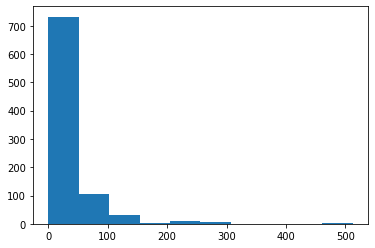

In [508]:
plt.hist(data['Fare'])

In [509]:
data['Parch'].unique()

array([0, 1, 2, 5, 3, 4, 6])

In [510]:
data = Supervised_Path(train_data=data, target_variable='Survived',
                    time_features=[], features_to_drop=['PassengerId'],numeric_imputation_strategy="mean",
                    categorical_imputation_strategy="most frequent",
                    apply_zero_nearZero_variance=True,
                    apply_grouping=False, group_name='new', features_to_group_ListofList=[[]],
                    nominal_encoding=True, top=10, nominal_encoding_method ='one hot', features_for_nominal_encode=[],
                    ordinal_encoding=True, ordinal_encoding_method ='simple label', features_for_ordinal_encode=[],
                    scale_data=True, scaling_method='minmax',
                    target_transformation=True, Power_transform_data='bc')

In [511]:
data

,Survived,Pclass,Age,SibSp,Parch,Fare,"Carlsson, Mr. Frans Olof","Cavendish, Mr. Tyrell William","Panula, Mrs. Juha (Maria Emilia Ojala)","Lefebre, Master. Henry Forbes",...,E101,F2,C22 C26,F33,D,D20,B57 B59 B63 B66,S,C,Q
0,0,1.0,0.271174,0.125,0.000000,0.014151,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0.0,0.472229,0.125,0.000000,0.139136,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,1.0,0.321438,0.000,0.000000,0.015469,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,0.0,0.434531,0.125,0.000000,0.103644,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,1.0,0.434531,0.000,0.000000,0.015713,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0.5,0.334004,0.000,0.000000,0.025374,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
887,1,0.0,0.233476,0.000,0.000000,0.058556,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
888,0,1.0,0.367921,0.125,0.333333,0.045771,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
889,1,0.0,0.321438,0.000,0.000000,0.058556,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


(array([732., 106.,  31.,   2.,  11.,   6.,   0.,   0.,   0.,   3.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

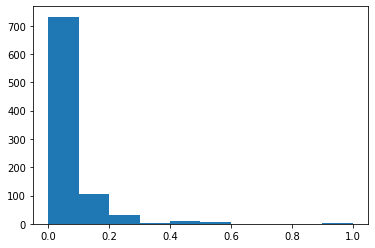

In [512]:
plt.hist(data['Fare'])

In [513]:
class Outliers(BaseEstimator, TransformerMixin):
    '''
        Only takes numerical or one hot encoded data
    '''
    def __init__(self, target):
        self.target = target
        
    def fit(self, dataset, y=None):
        return None
    
    def transform(self, dataset, y=None):
        return None
    
    def fit_transform(self, dataset, y=None):
        data = dataset.copy()
        
        
        
        
        return data

In [519]:
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
from pyod.models.pca import PCA as PCA_RO
from sklearn.covariance import EllipticEnvelope

# https://machinelearningmastery.com/model-based-outlier-detection-and-removal-in-python/
class Remove_Outliers(BaseEstimator,TransformerMixin):
    def __init__(self,target,contamination=.20, random_state=42, methods=['knn','iso','mcd']):
        
        self.target = target
        self.contamination = contamination
        self.random_state = random_state
        self.methods = methods

    def fit(self,data,y=None):
        return(None)

    def transform(self,data,y=None):
        return(data)

    def fit_transform(self,dataset,y=None):
        data = dataset.copy()
        
        if 'iso' in self.methods:
            self.iso_forest = IForest(contamination=self.contamination,random_state=self.random_state,behaviour='new')
            self.iso_forest.fit(data.drop(self.target,axis=1))
            iso_predict = self.iso_forest.predict(data.drop(self.target,axis=1))
            data['iso'] = iso_predict
        
        if 'knn' in self.methods:
            self.knn_out = KNN(contamination=self.contamination)
            self.knn_out.fit(data.drop(self.target,axis=1))
            knn_predict = self.knn_out.predict(data.drop(self.target,axis=1))
            data['knn'] = knn_predict
            
        if 'pca' in self.methods:
            self.out_pca = PCA_RO(contamination=self.contamination,random_state=self.random_state)
            self.out_pca.fit(data.drop(self.target,axis=1))
            pca_predict = self.out_pca.predict(data.drop(self.target,axis=1))
            data['pca'] = pca_predict
        
        # use for those features which are gaussian distributed
        if 'mcd' in self.methods:
            self.mcd = EllipticEnvelope(contamination=0.01)
            self.mcd.fit(data.drop(self.target, axis=1))
            mcd_predict = self.mcd.predict(data.drop(self.target, axis=1))
            data['mcd'] = mcd_predict

        data['vote_outlier'] = 0
    
        for i in self.methods:
            data['vote_outlier'] = data['vote_outlier'] + data[i]
    

        self.outliers = data[data['vote_outlier']== len(self.methods)]
    
        return dataset[[True if i not in self.outliers.index else False for i in dataset.index]]

In [515]:
obj = Remove_Outliers(target='Survived' ,methods=['iso','knn'])

In [516]:
data = obj.fit_transform(data)

In [517]:
data

,Survived,Pclass,Age,SibSp,Parch,Fare,"Carlsson, Mr. Frans Olof","Cavendish, Mr. Tyrell William","Panula, Mrs. Juha (Maria Emilia Ojala)","Lefebre, Master. Henry Forbes",...,E101,F2,C22 C26,F33,D,D20,B57 B59 B63 B66,S,C,Q
0,0,1.0,0.271174,0.125,0.000000,0.014151,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0.0,0.472229,0.125,0.000000,0.139136,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,1.0,0.321438,0.000,0.000000,0.015469,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,0.0,0.434531,0.125,0.000000,0.103644,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,1.0,0.434531,0.000,0.000000,0.015713,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0.5,0.334004,0.000,0.000000,0.025374,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
887,1,0.0,0.233476,0.000,0.000000,0.058556,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
888,0,1.0,0.367921,0.125,0.333333,0.045771,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
889,1,0.0,0.321438,0.000,0.000000,0.058556,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


(array([602.,   0.,  74.,   0.,  31.,   0.,   4.,   0.,   1.,   1.]),
 array([0.        , 0.08333333, 0.16666667, 0.25      , 0.33333333,
        0.41666667, 0.5       , 0.58333333, 0.66666667, 0.75      ,
        0.83333333]),
 <BarContainer object of 10 artists>)

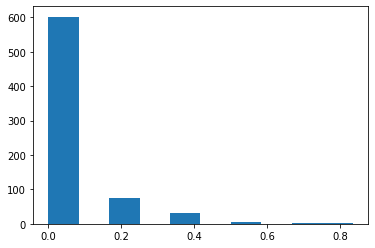

In [457]:
plt.hist(data['Parch'])

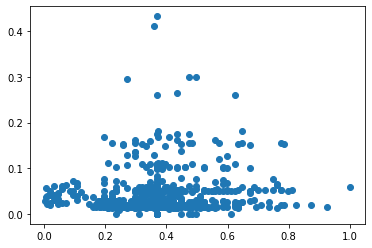

In [458]:
plt.scatter(data['Age'], data['Fare'])

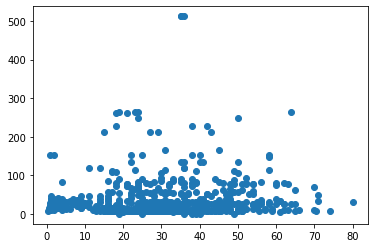

In [460]:
plt.scatter(data['Age'], data['Fare'])

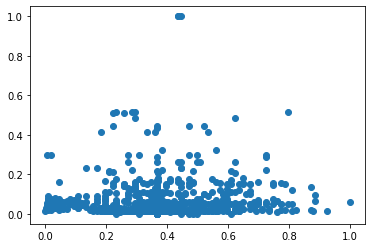

In [466]:
plt.scatter(data['Age'], data['Fare'])

In [528]:
auto_mobile = pd.read_csv('automobile.csv')
auto_mobile.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.4,10.0,102,5500,24,30,13950
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.4,8.0,115,5500,18,22,17450


In [529]:
auto_mobile.describe()

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,compression-ratio,city-mpg,highway-mpg,price
count,202.000000,165.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000
mean,0.831683,121.836364,98.848020,174.273267,65.903960,53.775248,2558.173267,126.945545,10.160990,25.148515,30.658416,13253.752475
std,1.258360,35.396412,6.094523,12.334330,2.106915,2.444769,517.236654,41.455269,3.995264,6.421956,6.809940,7954.919591
min,-2.000000,65.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,7.000000,13.000000,16.000000,5118.000000
25%,0.000000,94.000000,94.500000,166.800000,64.125000,52.000000,2174.250000,98.000000,8.600000,19.000000,25.000000,7778.250000
50%,1.000000,115.000000,97.000000,173.200000,65.500000,54.100000,2417.000000,120.000000,9.000000,24.000000,30.000000,10320.000000
75%,2.000000,150.000000,102.400000,183.500000,66.825000,55.500000,2932.750000,141.000000,9.400000,30.000000,34.000000,16502.250000
max,3.000000,256.000000,120.900000,208.100000,72.000000,59.800000,4066.000000,326.000000,23.000000,49.000000,54.000000,45400.000000


In [530]:
data = Supervised_Path(train_data=auto_mobile, target_variable='price',
                    time_features=[], features_to_drop=[''],numeric_imputation_strategy="mean",
                    categorical_imputation_strategy="most frequent",
                    apply_zero_nearZero_variance=True,
                    apply_grouping=False, group_name='new', features_to_group_ListofList=[[]],
                    nominal_encoding=True, top=10, nominal_encoding_method ='one hot', features_for_nominal_encode=[],
                    ordinal_encoding=True, ordinal_encoding_method ='simple label', features_for_ordinal_encode=[],
                    scale_data=False, scaling_method='minmax',
                    target_transformation=True, Power_transform_data='bc')

In [531]:
obj = Remove_Outliers(target='price' ,methods=['iso','knn'])

In [532]:
data = obj.fit_transform(data)

In [533]:
data.describe()

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,compression-ratio,city-mpg,...,4800,5500,5000,5200,5400,6000,5800,4500,5250,4150
count,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,...,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000
mean,0.860215,121.637634,98.440323,173.582796,65.712903,53.730645,2503.354839,122.623656,9.847957,25.311828,...,0.177419,0.193548,0.139785,0.107527,0.064516,0.043011,0.037634,0.026882,0.037634,0.021505
std,1.248492,31.376740,5.448872,11.367713,1.855291,2.317915,458.414132,33.443592,3.580325,5.947479,...,0.383054,0.396145,0.347700,0.310618,0.246333,0.203429,0.190824,0.162174,0.190824,0.145453
min,-2.000000,65.000000,86.600000,144.600000,61.800000,48.800000,1819.000000,70.000000,7.000000,15.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,101.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,98.000000,8.525000,19.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,121.836364,96.750000,173.000000,65.400000,54.100000,2403.000000,110.000000,9.000000,25.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,140.750000,101.200000,180.200000,66.500000,55.500000,2821.750000,140.000000,9.400000,30.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.000000,256.000000,115.600000,202.600000,71.700000,59.800000,4066.000000,258.000000,23.000000,45.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
